# Regression with a Mohs Hardness Dataset

__Aim__: predict the Mohs hardness of a mineral, given its properties.

__Link to the competition__: [\<click!\>](https://www.kaggle.com/competitions/playground-series-s3e25)

__Score__: MedAE = 0.479

___

### APPROACH
The approach of this work can be described as follows:
1. brief EDA
2. data preprocessing
3. evaluate approach (regression, classification, combined approach, partial regression)
4. feature engineering (clustering with different group of features)
5. evaluate the basic models for regression approach
6. create the ensembles of best-performing basic models for regression approach
7. define the best regressor model
8. evaluate the basic models for classification approach
9. create the ensembles of best-performing basic models for classification approach
10. define the best classifier model
11. combine the best regressor model and the best classifier model and get the predictions

___

### IMPORTS

In [1]:
# main modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

In [1097]:
# modules used in data processing
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures, StandardScaler, PowerTransformer
from sklearn.kernel_approximation import Nystroem
from sklearn.metrics import median_absolute_error
from sklearn.cluster import KMeans

In [3]:
# classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [ ]:
# regressors
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor, AdaBoostRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

___

### READ TRAIN SET

In [7]:
train = pd.read_csv('train.csv', index_col='id').reset_index(drop=True)
train

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,100.0,0.841611,10.000000,4.800000,20.612526,11.088100,2.766000,1.732000,0.860000,0.496070,0.91457,6.0
1,100.0,7.558488,10.000000,4.800000,20.298893,12.040830,2.755000,1.631000,0.910000,0.492719,0.71760,6.5
2,76.0,8.885992,15.600000,5.600000,33.739258,12.086300,2.828000,1.788000,0.864000,0.481478,1.50633,2.5
3,100.0,8.795296,10.000000,4.800000,20.213349,10.948500,2.648000,1.626000,0.936000,0.489272,0.78937,6.0
4,116.0,9.577996,11.600000,4.800000,24.988133,11.824480,2.766000,1.682000,0.896000,0.492736,1.86481,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10402,128.0,7.558488,12.000000,4.000000,26.385218,11.330440,2.644000,1.631000,0.892000,0.496070,1.79607,4.0
10403,30.0,1.743160,10.000000,5.333333,20.766935,14.163933,3.090000,1.556667,0.866667,0.480390,0.81480,5.0
10404,196.0,30.920000,24.500000,5.500000,53.490297,10.074300,2.295000,1.545000,1.120000,0.469715,2.11540,1.8
10405,38.0,1.553160,12.666667,4.666667,26.621687,11.290033,2.743333,1.756667,0.980000,0.486507,0.77755,6.0


___

### EDA

In [10]:
# doesn't df have missing values?
train.notna().all().all()

True

In [12]:
# does df have duplicated rows?
train.duplicated().any()

False

In [14]:
len(train.columns)

12

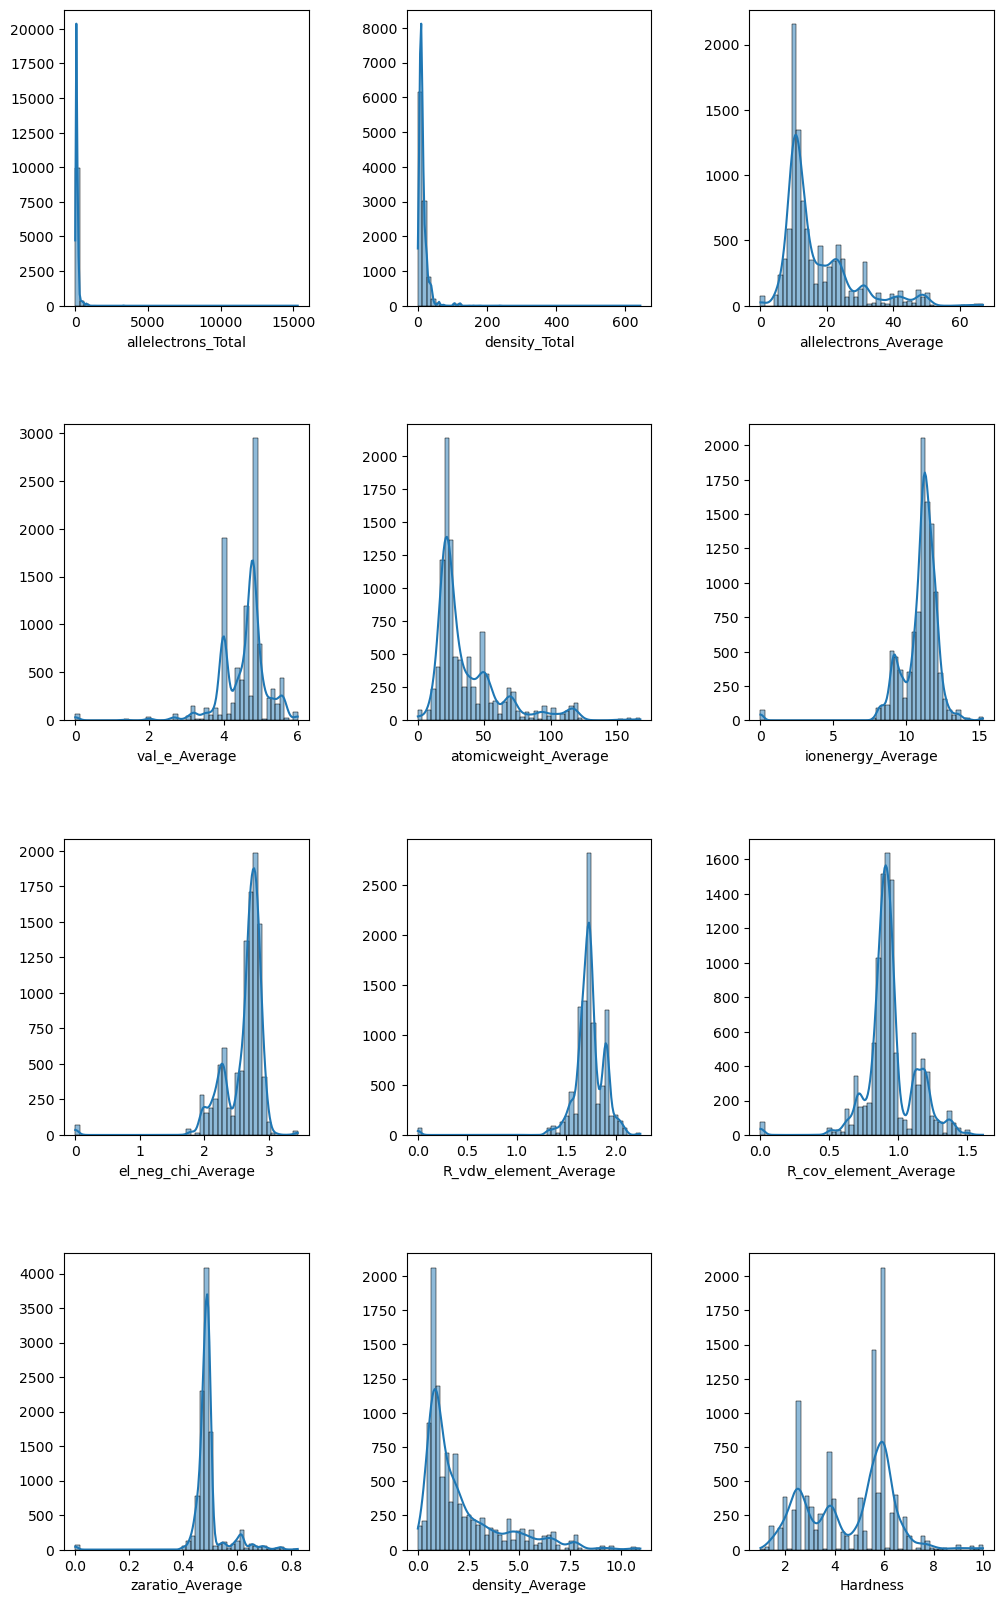

In [38]:
# plot distributions of each feature
fig, axs = plt.subplots(nrows=4, 
                        ncols=3, 
                        figsize=(12, 20))
for feature, ax in zip(train.columns, axs.ravel()):
    sns.histplot(data=train, 
                 x=feature, 
                 ax=ax, 
                 bins=50, 
                 kde=True)
    ax.set(ylabel='')
plt.subplots_adjust(wspace=.4, hspace=.4)

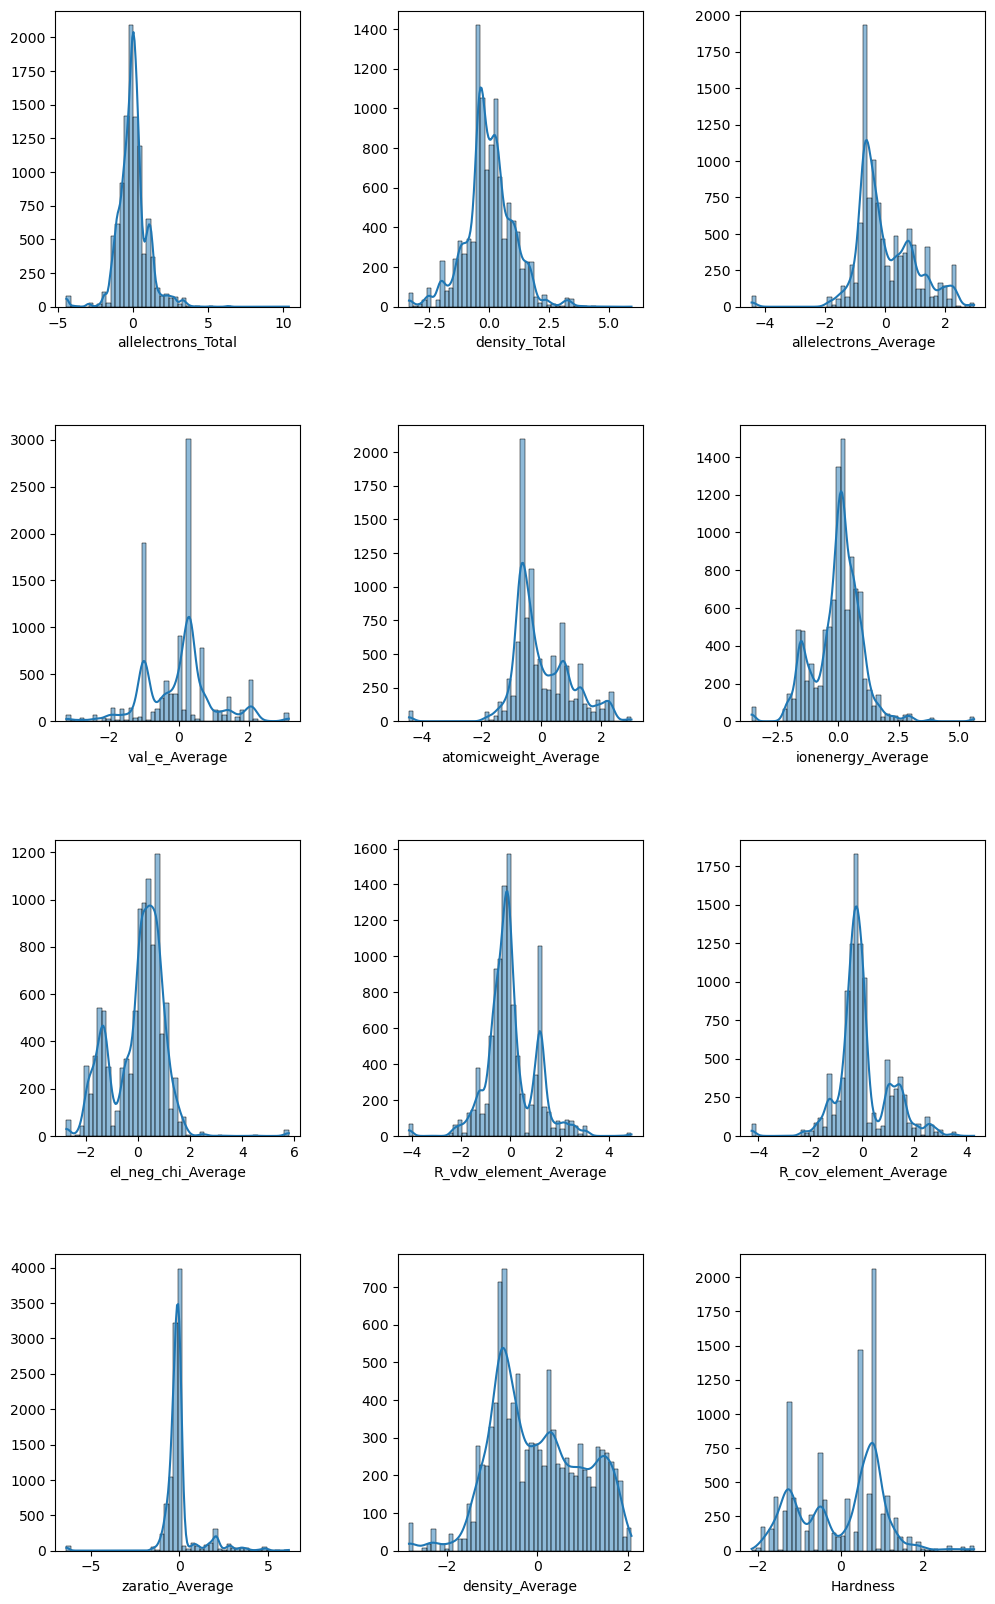

In [45]:
# plot distributions of each feature after normalization
fig, axs = plt.subplots(nrows=4, 
                        ncols=3, 
                        figsize=(12, 20))
for feature, ax in zip(train.columns, axs.ravel()):
    sns.histplot(data=PowerTransformer().fit_transform(train[feature].values.reshape(-1,1)), 
                 ax=ax, 
                 bins=50, 
                 kde=True, 
                 legend=False)
    ax.set(ylabel='')
    ax.set(xlabel=feature)
plt.subplots_adjust(wspace=.4, hspace=.4)

___

### DATA PREPROCESSING and APPROACH SELECTION

In [687]:
# define classes label-values pairs to apply classification approach
target_dict = {
    '0': [1.00, 1.95],
    '1': [1.95, 2.85],
    '2': [2.85, 4.75],
    '3': [4.75, 5.25],
    '4': [5.25, 5.75],
    '5': [5.75, 6.25],
    '6': [6.25, 6.75],
    '7': [6.75, 7.25],
    '8': [7.25, 7.75],
    '9': [7.75, 8.75],
    '10': [8.75, 10.00]
}

def set_target_classes(target):
    """Func sets class labels depending on the values of target"""
    code = 0
    for key, values in target_dict.items():
        if target >= values[0] and target <= values[1]:
            code = key
            return code
    return code

def set_target_means_for_classes(target):
    """Func sets values (means) depending on the class labels of target"""
    return np.mean(target_dict[str(target)])

def reform_target_to_multiclass(df):
    """Func reforms target from float to multiclass"""
    df = df.copy()
    df['Hardness_Multiclass'] = df.Hardness.apply(set_target_classes).astype(int)
    df.drop('Hardness', axis=1, inplace=True)
    return df

def reform_target_to_float(df):
    """Func reforms target from multiclass to float"""
    df = df.copy()
    df['Hardness'] = df.Hardness_Multiclass.apply(set_target_means_for_classes)
    df.drop('Hardness_Multiclass', axis=1, inplace=True)
    return df

In [841]:
def evaluate_transform_combined_approach(df_initial, # initial dataframe
                                         reforming_function=lambda df: df, # func to reform target for classification
                                         inverse_reforming_function=lambda df: df, # func to reform target back
                                         transform=lambda df: df, # func to transform dataframe
                                         inverse_target_transform=lambda df, y: y): # func to transform target back
    """Func evaluates transform of the df"""
    df_initial = df_initial.copy()
    
    # CLASSIFICATION
    
    df_transformed_cl = transform(df_initial).copy()
    # drop transformed target
    df_transformed_cl.drop('Hardness', axis=1, inplace=True) 
    # retain initial target
    df_transformed_cl['Hardness'] = df_initial.Hardness 
    # get dataframe with reformed target
    df_reformed = reforming_function(df_transformed_cl)
    # now df_reformed has transformed features and reformed target named 'Hardness_Multiclass'
    # split dataframe into train and test sets
    X_cl = df_reformed.drop('Hardness_Multiclass', axis=1)
    y_cl = df_reformed.Hardness_Multiclass
    X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(X_cl, 
                                                                    y_cl, 
                                                                    test_size=0.3, 
                                                                    random_state=1)
    # train classification model and get predictions
    cl = XGBClassifier(n_estimators=100)
    cl.fit(X_train_cl, y_train_cl)
    preds_cl = cl.predict(X_test_cl)
    # reform predictions back to float
    y_pred_cl = np.array(inverse_reforming_function(pd.DataFrame({'Hardness_Multiclass': preds_cl})).Hardness.values)
#     print('cl:', y_pred_cl)
    
    # REGRESSION
    
    df_transformed_reg = transform(df_initial).copy()
    # now df_transformed_reg has transformed features and transformed target named 'Hardness'
    # split dataframe into train and test sets according to split made for classification (same entries)
    X_reg = df_transformed_reg.drop('Hardness', axis=1)
    y_reg = df_transformed_reg.Hardness
    train_indicies = X_train_cl.index
    test_indicies = X_test_cl.index
    X_train_reg = X_reg.iloc[train_indicies]
    X_test_reg = X_reg.iloc[test_indicies]
    y_train_reg = y_reg.iloc[train_indicies]
    y_test_reg = y_reg.iloc[test_indicies]
    # train regression model and get predictions
    reg = XGBRegressor(n_estimators=100)
    reg.fit(X_train_reg, y_train_reg)
    preds_reg = reg.predict(X_test_reg)
    # inverse transform predictions
    preds_reg = inverse_target_transform(df_initial, preds_reg)
    y_pred_reg = np.array(preds_reg)
#     print('reg:', y_pred_reg)
    
    # COMBINED APPROACH
    
    # calculate predictions obtained with classification and regression
    y_pred = (y_pred_cl + y_pred_reg) / 2
#     print('comb:', y_pred)
    # define true values of target
    y_true = np.array(df_initial.iloc[test_indicies].Hardness)
#     print('true:', y_true)
    # create dict with scores
    result = {
        'classification': median_absolute_error(y_true, y_pred_cl),
        'regression': median_absolute_error(y_true, y_pred_reg),
        'combined': median_absolute_error(y_true, y_pred)
    }
    return result

In [842]:
# evaluate initial df (base score with no feature engineering, data preprocessing, etc.)
evaluate_transform_combined_approach(df_initial=train,
                                     reforming_function=reform_target_to_multiclass,
                                     inverse_reforming_function=reform_target_to_float)

{'classification': 0.5,
 'regression': 0.6802160739898682,
 'combined': 0.5118606090545654}

#### Test normalization

In [843]:
def apply_yeo_johnson_normalization(df):
    """Func applies Yeo-Johnson normalization"""
    df = df.copy()
    for feature in df.columns:
        power_transformer = PowerTransformer()
        transformed_values = power_transformer.fit_transform(df[feature].values.reshape(-1,1))
        df[feature] = pd.DataFrame({feature: np.array(transformed_values.flatten())})
    return df

def inverse_target_yeo_johnson_normalization(df, normalized_target):
    """Func transforms target back after Yeo-Johnson normalization"""
    power_transformer = PowerTransformer()
    power_transformer.fit(df.Hardness.values.reshape(-1, 1))
    return power_transformer.inverse_transform(np.array(normalized_target).reshape(-1, 1)).flatten()

In [844]:
# evaluate Yeo-Johnson normalization
evaluate_transform_combined_approach(df_initial=train,
                                     reforming_function=reform_target_to_multiclass,
                                     inverse_reforming_function=reform_target_to_float,
                                     transform=apply_yeo_johnson_normalization,
                                     inverse_target_transform=inverse_target_yeo_johnson_normalization)

{'classification': 0.5,
 'regression': 0.6777544021606445,
 'combined': 0.5295982360839844}

In [845]:
def apply_minmax_normalization(df):
    """Func applies MinMax normalization"""
    df = df.copy()
    for feature in df.columns:
        scaler = MinMaxScaler()
        transformed_values = scaler.fit_transform(df[feature].values.reshape(-1,1))
        df[feature] = pd.DataFrame({feature: np.array(transformed_values.flatten())})
    return df

def inverse_target_minmax_normalization(df, normalized_target):
    """Func transforms target back after MinMax normalization"""
    scaler = MinMaxScaler()
    scaler.fit(df.Hardness.values.reshape(-1, 1))
    return scaler.inverse_transform(np.array(normalized_target).reshape(-1, 1)).flatten()

In [846]:
# evaluate MinMax normalization
evaluate_transform_combined_approach(df_initial=train,
                                     reforming_function=reform_target_to_multiclass,
                                     inverse_reforming_function=reform_target_to_float,
                                     transform=apply_minmax_normalization,
                                     inverse_target_transform=inverse_target_minmax_normalization)

{'classification': 0.5,
 'regression': 0.6796112060546875,
 'combined': 0.5104999542236328}

#### Test target transform to absolute scale

In [849]:
# df to train model to get absolute hardness from hardness and vice versa
df_hardness_train = pd.DataFrame({'Hardness': range(1, 11),
                                  'Absolute_Hardness': [1, 2, 14, 21, 48, 72, 100, 200, 400, 1500]})

def apply_mohs_to_absolute_transform(df):
    """Func transforms target from Mohs to absolute scale"""
    df = df.copy()
    X_hardness_train = df_hardness_train.Hardness
    y_hardness_train = df_hardness_train.Absolute_Hardness
    mohs_to_absolute_regressor = XGBRegressor()
    mohs_to_absolute_regressor.fit(X_hardness_train, df_hardness_train.Absolute_Hardness)
    X_hardness = df.Hardness
    absolute_hardness = mohs_to_absolute_regressor.predict(X_hardness)
    df['Hardness'] = absolute_hardness
    return df

def inverse_mohs_to_absolute_transform(df, absolute_target):
    """Func transforms target from absolute to Mohs scale"""
    df = df.copy()
    X_hardness_train = df_hardness_train.Absolute_Hardness
    y_hardness_train = df_hardness_train.Hardness
    absolute_to_mohs_regressor = XGBRegressor()
    absolute_to_mohs_regressor.fit(X_hardness_train, df_hardness_train.Hardness)
    X_hardness = absolute_target
    hardness = absolute_to_mohs_regressor.predict(X_hardness)
    return hardness

In [850]:
# evaluate df with the target transformed to absolute scale
evaluate_transform_combined_approach(df_initial=train,
                                     reforming_function=reform_target_to_multiclass,
                                     inverse_reforming_function=reform_target_to_float,
                                     transform=apply_mohs_to_absolute_transform,
                                     inverse_target_transform=inverse_mohs_to_absolute_transform)

{'classification': 0.5,
 'regression': 0.9986915588378906,
 'combined': 0.6005731582641598}

#### Test clustering function over non-normalized data

In [851]:
def find_best_n_for_clustering_by_features(df, features):
    """Func searches the optimal n_clusters for clustering by features"""
    df = df.copy()
    print('searching the best n for clustering by {} ...\n\t...'.format(features), end='')
    best_score = evaluate_transform_combined_approach(df_initial=df,
                                                      reforming_function=reform_target_to_multiclass,
                                                      inverse_reforming_function=reform_target_to_float)
    best_i = None
    print('\tn: {}, scores: {:.4} (cl), {:.4} (reg), {:.4} (comb) / base'.format(best_i, *best_score.values()))
    for i in range(2, 9):
        print('\t...', end='')
        clusterizer = KMeans(n_clusters=i, 
                             n_init=10, 
                             random_state=1)
        clusterizer.fit(df[features])
        new_features = clusterizer.predict(df[features])
        label = '_'.join(features) + '_cl'
        current_score = evaluate_transform_combined_approach(df_initial=pd.concat([df, 
                                                                                   pd.DataFrame({label: new_features})], 
                                                                                  axis=1),
                                                             reforming_function=reform_target_to_multiclass,
                                                             inverse_reforming_function=reform_target_to_float)
        print('\tn: {}, scores: {:.4} (cl), {:.4} (reg), {:.4} (comb)'.format(i, *current_score.values()))
        if current_score['combined'] < best_score['combined']:
            best_score = current_score
            best_i = i
    return best_i, best_score

In [852]:
# TEST
# find_best_n_for_clustering_by_features(df=train, 
#                                        features=['density_Total', 'density_Average'])

In [853]:
def clustering_search(df, feature_groups):
    """Func searches the optimal clustering by groups of features"""
    df = df.copy()
    log_df = pd.DataFrame({'features': [], 
                           'best_n': [], 
                           'score_cl': [],
                           'score_reg': [],
                           'score_comb': []})
    base_score = evaluate_transform_combined_approach(df_initial=df,
                                                      reforming_function=reform_target_to_multiclass,
                                                      inverse_reforming_function=reform_target_to_float)
    log_df = pd.concat([log_df, 
                        pd.DataFrame({
                            'features': [None], 
                            'best_n': [None], 
                            'score_cl': [base_score['classification']],
                            'score_reg': [base_score['regression']],
                            'score_comb': [base_score['combined']]})], 
                       axis=0, 
                       ignore_index=True)
    for features in feature_groups:
        best_n, best_score = find_best_n_for_clustering_by_features(df=df, features=features)
        log_df = pd.concat([log_df, 
                            pd.DataFrame({'features': [features], 
                                          'best_n': [best_n], 
                                          'score_cl': [best_score['classification']],
                                          'score_reg': [best_score['regression']],
                                          'score_comb': [best_score['combined']]})], 
                           axis=0, 
                           ignore_index=True)
    return log_df.sort_values(by='score_comb', ascending=True).reset_index(drop=True)

In [854]:
# define the groups of features to search the best clustering by 
clustering_feature_groups = [
    ['allelectrons_Total', 'allelectrons_Average'],
    ['density_Total', 'density_Average'],
    ['density_Total', 'density_Average', 'zaratio_Average'],
    ['allelectrons_Average', 'val_e_Average'],
    ['R_vdw_element_Average', 'R_cov_element_Average'],
    ['atomicweight_Average', 'ionenergy_Average']
]

# conduct the research
clustering_search_df = clustering_search(df=train, feature_groups=clustering_feature_groups)
clustering_search_df

searching the best n for clustering by ['allelectrons_Total', 'allelectrons_Average'] ...
	...	n: None, scores: 0.5 (cl), 0.6802 (reg), 0.5119 (comb) / base
	...	n: 2, scores: 0.5 (cl), 0.6802 (reg), 0.5119 (comb)
	...	n: 3, scores: 0.5 (cl), 0.6802 (reg), 0.5119 (comb)
	...	n: 4, scores: 0.5 (cl), 0.6802 (reg), 0.5267 (comb)
	...	n: 5, scores: 0.5 (cl), 0.6723 (reg), 0.5024 (comb)
	...	n: 6, scores: 0.5 (cl), 0.685 (reg), 0.5108 (comb)
	...	n: 7, scores: 0.5 (cl), 0.6845 (reg), 0.5172 (comb)
	...	n: 8, scores: 0.5 (cl), 0.6822 (reg), 0.5209 (comb)
searching the best n for clustering by ['density_Total', 'density_Average'] ...
	...	n: None, scores: 0.5 (cl), 0.6802 (reg), 0.5119 (comb) / base
	...	n: 2, scores: 0.5 (cl), 0.6802 (reg), 0.5119 (comb)
	...	n: 3, scores: 0.5 (cl), 0.6813 (reg), 0.5059 (comb)
	...	n: 4, scores: 0.5 (cl), 0.6814 (reg), 0.521 (comb)
	...	n: 5, scores: 0.5 (cl), 0.672 (reg), 0.5279 (comb)
	...	n: 6, scores: 0.5 (cl), 0.6834 (reg), 0.5167 (comb)
	...	n: 7, scor

,features,best_n,score_cl,score_reg,score_comb
0,"[atomicweight_Average, ionenergy_Average]",3,0.5,0.689085,0.501345
1,"[allelectrons_Total, allelectrons_Average]",5,0.5,0.672303,0.502396
2,"[density_Total, density_Average]",3,0.5,0.681254,0.505931
3,"[density_Total, density_Average, zaratio_Average]",3,0.5,0.681254,0.505931
4,"[allelectrons_Average, val_e_Average]",6,0.5,0.679458,0.506791
5,None,None,0.5,0.680216,0.511861
6,"[R_vdw_element_Average, R_cov_element_Average]",None,0.5,0.680216,0.511861


#### Test clustering function over normalized data

In [859]:
# SAME AS ABOVE, just with the normalization

def find_best_n_for_clustering_by_features(df, features):
    """Func searches the optimal n_clusters for clustering by features"""
    df = df.copy()
    print('searching the best n for clustering by {} ...\n\t...'.format(features), end='')
    best_score = evaluate_transform_combined_approach(df_initial=df,
                                                      reforming_function=reform_target_to_multiclass,
                                                      inverse_reforming_function=reform_target_to_float,
                                                      transform=apply_minmax_normalization,
                                                      inverse_target_transform=inverse_target_minmax_normalization)
    best_i = None
    print('\tn: {}, scores: {:.4} (cl), {:.4} (reg), {:.4} (comb) / base'.format(best_i, *best_score.values()))
    for i in range(2, 9):
        print('\t...', end='')
        clusterizer = KMeans(n_clusters=i, 
                             n_init=10, 
                             random_state=1)
        clusterizer.fit(df[features])
        new_features = clusterizer.predict(df[features])
        label = '_'.join(features) + '_cl'
        current_score = evaluate_transform_combined_approach(df_initial=pd.concat([df, 
                                                                                   pd.DataFrame({label: new_features})], 
                                                                                  axis=1),
                                                             reforming_function=reform_target_to_multiclass,
                                                             inverse_reforming_function=reform_target_to_float,
                                                             transform=apply_minmax_normalization,
                                                             inverse_target_transform=inverse_target_minmax_normalization)
        print('\tn: {}, scores: {:.4} (cl), {:.4} (reg), {:.4} (comb)'.format(i, *current_score.values()))
        if current_score['combined'] < best_score['combined']:
            best_score = current_score
            best_i = i
    return best_i, best_score

In [860]:
# TEST
# find_best_n_for_clustering_by_features(df=train, 
#                                        features=['density_Total', 'density_Average'])

In [861]:
# SAME AS ABOVE, just with the normalization

def clustering_search(df, feature_groups):
    """Func searches the optimal clustering by groups of features"""
    df = df.copy()
    log_df = pd.DataFrame({'features': [], 
                           'best_n': [], 
                           'score_cl': [],
                           'score_reg': [],
                           'score_comb': []})
    base_score = evaluate_transform_combined_approach(df_initial=df,
                                                      reforming_function=reform_target_to_multiclass,
                                                      inverse_reforming_function=reform_target_to_float,
                                                      transform=apply_minmax_normalization,
                                                      inverse_target_transform=inverse_target_minmax_normalization)
    log_df = pd.concat([log_df, 
                        pd.DataFrame({
                            'features': [None], 
                            'best_n': [None], 
                            'score_cl': [base_score['classification']],
                            'score_reg': [base_score['regression']],
                            'score_comb': [base_score['combined']]})], 
                       axis=0, 
                       ignore_index=True)
    for features in feature_groups:
        best_n, best_score = find_best_n_for_clustering_by_features(df=df, features=features)
        log_df = pd.concat([log_df, 
                            pd.DataFrame({'features': [features], 
                                          'best_n': [best_n], 
                                          'score_cl': [best_score['classification']],
                                          'score_reg': [best_score['regression']],
                                          'score_comb': [best_score['combined']]})], 
                           axis=0, 
                           ignore_index=True)
    return log_df.sort_values(by='score_comb', ascending=True).reset_index(drop=True)

In [862]:
# SAME AS ABOVE, just with the normalization

clustering_feature_groups = [
    ['allelectrons_Total', 'allelectrons_Average'],
    ['density_Total', 'density_Average'],
    ['density_Total', 'density_Average', 'zaratio_Average'],
    ['allelectrons_Average', 'val_e_Average'],
    ['R_vdw_element_Average', 'R_cov_element_Average'],
    ['atomicweight_Average', 'ionenergy_Average']
]

clustering_search_df = clustering_search(df=train, feature_groups=clustering_feature_groups)
clustering_search_df

searching the best n for clustering by ['allelectrons_Total', 'allelectrons_Average'] ...
	...	n: None, scores: 0.5 (cl), 0.6796 (reg), 0.5105 (comb) / base
	...	n: 2, scores: 0.5 (cl), 0.6796 (reg), 0.5105 (comb)
	...	n: 3, scores: 0.5 (cl), 0.6796 (reg), 0.5105 (comb)
	...	n: 4, scores: 0.5 (cl), 0.6796 (reg), 0.5194 (comb)
	...	n: 5, scores: 0.5 (cl), 0.6789 (reg), 0.5129 (comb)
	...	n: 6, scores: 0.5 (cl), 0.6789 (reg), 0.5219 (comb)
	...	n: 7, scores: 0.5 (cl), 0.6901 (reg), 0.5229 (comb)
	...	n: 8, scores: 0.5 (cl), 0.6788 (reg), 0.5241 (comb)
searching the best n for clustering by ['density_Total', 'density_Average'] ...
	...	n: None, scores: 0.5 (cl), 0.6796 (reg), 0.5105 (comb) / base
	...	n: 2, scores: 0.5 (cl), 0.6796 (reg), 0.5105 (comb)
	...	n: 3, scores: 0.5 (cl), 0.7036 (reg), 0.5166 (comb)
	...	n: 4, scores: 0.5 (cl), 0.7036 (reg), 0.5244 (comb)
	...	n: 5, scores: 0.5 (cl), 0.6988 (reg), 0.5395 (comb)
	...	n: 6, scores: 0.5 (cl), 0.6851 (reg), 0.5172 (comb)
	...	n: 7, s

,features,best_n,score_cl,score_reg,score_comb
0,"[R_vdw_element_Average, R_cov_element_Average]",8,0.5,0.675486,0.508986
1,"[atomicweight_Average, ionenergy_Average]",3,0.5,0.674718,0.509867
2,None,None,0.5,0.679611,0.510500
3,"[allelectrons_Total, allelectrons_Average]",None,0.5,0.679611,0.510500
4,"[density_Total, density_Average]",None,0.5,0.679611,0.510500
5,"[density_Total, density_Average, zaratio_Average]",None,0.5,0.679611,0.510500
6,"[allelectrons_Average, val_e_Average]",None,0.5,0.679611,0.510500


#### Test multiclustering over normalized data

In [1075]:
def apply_clustering_by_features(df, 
                                 features, 
                                 n):
    """Func applies clustering by features"""
    df = df.copy()
    clusterizer = KMeans(n_clusters=n, 
                         n_init=10, 
                         random_state=1)
    clusterizer.fit(df[features])
    new_features = clusterizer.predict(df[features])
    label = '_'.join(features) + '_cl'
    return clusterizer, pd.concat([df, pd.DataFrame({label: new_features})], axis=1)

In [1076]:
def multiclustering_search(df, 
                           feature_groups, 
                           feature_groups_combinations, 
                           clustering_ns):   
    """Func conducts the multiclustering search (applies different combinations of basic clustering)"""
    log_df = pd.DataFrame({'combination': [],
                           'score_cl': [],
                           'score_reg': [],
                           'score_comb': []})
    base_score = evaluate_transform_combined_approach(df_initial=df,
                                                      reforming_function=reform_target_to_multiclass,
                                                      inverse_reforming_function=reform_target_to_float,
                                                      transform=apply_minmax_normalization,
                                                      inverse_target_transform=inverse_target_minmax_normalization)
    log_df = pd.concat([log_df, 
                        pd.DataFrame({
                            'combination': [None], 
                            'score_cl': [base_score['classification']],
                            'score_reg': [base_score['regression']],
                            'score_comb': [base_score['combined']]})], 
                       axis=0, 
                       ignore_index=True)
    for combination in feature_groups_combinations:
        df_with_clusters = df.copy()
        print('... scoring multiclustering by {} ...\n\t... '.format(combination), end='')
        for features in combination:
            n = clustering_ns[feature_groups.index(features)]
            _, df_with_clusters = apply_clustering_by_features(df_with_clusters, features, n)
        score = evaluate_transform_combined_approach(df_initial=df_with_clusters,
                                                     reforming_function=reform_target_to_multiclass,
                                                     inverse_reforming_function=reform_target_to_float,
                                                     transform=apply_minmax_normalization,
                                                     inverse_target_transform=inverse_target_minmax_normalization)
        log_df = pd.concat([log_df, 
                            pd.DataFrame({'combination': [combination], 
                                          'score_cl': [score['classification']],
                                          'score_reg': [score['regression']],
                                          'score_comb': [score['combined']]})], 
                           axis=0, 
                           ignore_index=True)
        print('done!')
    return log_df.sort_values(by='score_comb', ascending=True).reset_index(drop=True)

In [1077]:
# define the best clustering groups
best_clustering_feature_groups = [
    ['R_vdw_element_Average', 'R_cov_element_Average'],
    ['atomicweight_Average', 'ionenergy_Average']
]
# define the best numbers of clusters accordingly
best_clustering_ns = [8, 3]

# define all possible combinations of clustering groups
best_clustering_combinations = []
for i in range(1, len(best_clustering_feature_groups) + 1):
    for subset in itertools.combinations(best_clustering_feature_groups, i):
        best_clustering_combinations.append(list(subset))

# conduct the multiclustering research
multiclustering_search_df = multiclustering_search(train, 
                                                   best_clustering_feature_groups,
                                                   best_clustering_combinations, 
                                                   best_clustering_ns)
with pd.option_context('display.max_colwidth', None):
    display(multiclustering_search_df)

... scoring multiclustering by [['R_vdw_element_Average', 'R_cov_element_Average']] ...
	... done!
... scoring multiclustering by [['atomicweight_Average', 'ionenergy_Average']] ...
	... done!
... scoring multiclustering by [['R_vdw_element_Average', 'R_cov_element_Average'], ['atomicweight_Average', 'ionenergy_Average']] ...
	... done!


,combination,score_cl,score_reg,score_comb
0,"[[R_vdw_element_Average, R_cov_element_Average]]",0.5,0.675486,0.508986
1,"[[atomicweight_Average, ionenergy_Average]]",0.5,0.674718,0.509867
2,None,0.5,0.679611,0.510500
3,"[[R_vdw_element_Average, R_cov_element_Average], [atomicweight_Average, ionenergy_Average]]",0.5,0.675895,0.524399


#### Decision on preprocessing
* add MinMaxScaler()
* add clustering by \['atomicweight_Average', 'ionenergy_Average'\] with KMeans(n_clusters=3, n_init=10, random_state=1)

#### Test partial regression
(Partial regression is the combination of three regression models for different intervals of target values.)

In [1073]:
train_pr = train.copy()
transform = apply_minmax_normalization
inverse_target_transform = inverse_target_minmax_normalization

train_pr = transform(train_pr)
train_pr['Hardness'] = inverse_target_transform(train, train_pr['Hardness'])

def left_part_selector(y):
    if y <= 4:
        return 1
    else:
        return 0
    
def right_part_selector(y):
    if y >= 8:
        return 1
    else:
        return 0

def mid_part_selector(y):
    if 4 <= y <= 8:
        return 1
    else:
        return 0

train_pr['left_part'] = train_pr.Hardness.apply(left_part_selector)
train_pr['right_part'] = train_pr.Hardness.apply(right_part_selector)
train_pr['mid_part'] = train_pr.Hardness.apply(mid_part_selector)

X_pr = train_pr.drop(['left_part', 'right_part', 'mid_part', 'Hardness'], axis=1)
Y_pr = train_pr[['left_part', 'right_part', 'mid_part']]
X_train_pr, X_test_pr, y_train_pr, y_test_pr = train_test_split(X_pr, 
                                                                Y_pr, 
                                                                test_size=0.5, 
                                                                random_state=1)
y_train_pr_left = y_train_pr.left_part
y_train_pr_right = y_train_pr.right_part
y_train_pr_mid = y_train_pr.mid_part
y_test_pr_left = y_test_pr.left_part
y_test_pr_right = y_test_pr.right_part
y_test_pr_mid = y_test_pr.mid_part

left_part_classifier = XGBClassifier(n_estimators=110)
right_part_classifier = XGBClassifier(n_estimators=350)
mid_part_classifier = XGBClassifier(n_estimators=75)

left_part_classifier.fit(X_train_pr, y_train_pr_left)
right_part_classifier.fit(X_train_pr, y_train_pr_right)
mid_part_classifier.fit(X_train_pr, y_train_pr_mid)

preds_left = left_part_classifier.predict(X_test_pr)
preds_right = right_part_classifier.predict(X_test_pr)
preds_mid = mid_part_classifier.predict(X_test_pr)

print('left part classifier score:', roc_auc_score(y_test_pr_left, preds_left))
print('right part classifier score:', roc_auc_score(y_test_pr_right, preds_right))
print('mid part classifier score:', roc_auc_score(y_test_pr_mid, preds_mid))
print()

X_test_pr['left_part_predicted'] = preds_left
X_test_pr['right_part_predicted'] = preds_right
X_test_pr['mid_part_predicted'] = preds_mid

train_with_parts_predicted = X_test_pr.copy()
train_with_parts_predicted['Hardness'] = train_pr.iloc[train_with_parts_predicted.index].Hardness

X_pr = train_with_parts_predicted.drop('Hardness', axis=1)
y_pr = train_with_parts_predicted.Hardness
X_train_pr, X_test_pr, y_train_pr, y_test_pr = train_test_split(X_pr, 
                                                                y_pr, 
                                                                test_size=0.5, 
                                                                random_state=1)

left_part_indicies_train = X_train_pr.query('left_part_predicted == 1').index
right_part_indicies_train = X_train_pr.query('right_part_predicted == 1').index
mid_part_indicies_train = X_train_pr.query('mid_part_predicted == 1').index

left_part_indicies_test = X_test_pr.query('left_part_predicted == 1').index
right_part_indicies_test = X_test_pr.query('right_part_predicted == 1').index
mid_part_indicies_test = X_test_pr.query('mid_part_predicted == 1').index

# exception for the non-labeled class
if len(X_train_pr.query('left_part_predicted == 0 & right_part_predicted == 0 & mid_part_predicted == 0').index):
    no_part_indicies_train = X_train_pr.query('left_part_predicted == 0 & right_part_predicted == 0 & mid_part_predicted == 0').index
    no_part_indicies_test = X_test_pr.query('left_part_predicted == 0 & right_part_predicted == 0 & mid_part_predicted == 0').index
    X_train_no = X_train_pr.loc[no_part_indicies_train]
    X_test_no = X_test_pr.loc[no_part_indicies_test]
    y_train_no = y_train_pr.loc[no_part_indicies_train]
    y_test_no = y_test_pr.loc[no_part_indicies_test]
    no_part_regressor = XGBRegressor(n_estimators=100)
    no_part_regressor.fit(X_train_no, y_train_no)
    preds_no = pd.DataFrame(index=no_part_indicies_test)
    preds_no['Hardness_no'] = no_part_regressor.predict(X_test_no)
    print('no preds:\n', preds_no.head())
    print('no true:\n', y_test_no.head())
    print('no score:', median_absolute_error(y_test_no, preds_no))
    print()

X_train_pr = X_train_pr.drop(['left_part_predicted', 'right_part_predicted', 'mid_part_predicted'], axis=1)
X_train_left = X_train_pr.loc[left_part_indicies_train]
X_train_right = X_train_pr.loc[right_part_indicies_train]
X_train_mid = X_train_pr.loc[mid_part_indicies_train]

X_test_pr = X_test_pr.drop(['left_part_predicted', 'right_part_predicted', 'mid_part_predicted'], axis=1)
X_test_left = X_test_pr.loc[left_part_indicies_test]
X_test_right = X_test_pr.loc[right_part_indicies_test]
X_test_mid = X_test_pr.loc[mid_part_indicies_test]

y_train_left = y_train_pr.loc[left_part_indicies_train]
y_train_right = y_train_pr.loc[right_part_indicies_train]
y_train_mid = y_train_pr.loc[mid_part_indicies_train]

y_test_left = y_test_pr.loc[left_part_indicies_test]
y_test_right = y_test_pr.loc[right_part_indicies_test]
y_test_mid = y_test_pr.loc[mid_part_indicies_test]

left_part_regressor = XGBRegressor(n_estimators=100)
right_part_regressor = XGBRegressor(n_estimators=100)
mid_part_regressor = XGBRegressor(n_estimators=100)

left_part_regressor.fit(X_train_left, y_train_left)
right_part_regressor.fit(X_train_right, y_train_right)
mid_part_regressor.fit(X_train_mid, y_train_mid)

preds_left = pd.DataFrame(index=left_part_indicies_test)
preds_left['Hardness_left'] = left_part_regressor.predict(X_test_left)
preds_right = pd.DataFrame(index=right_part_indicies_test)
preds_right['Hardness_right'] = right_part_regressor.predict(X_test_right)
preds_mid = pd.DataFrame(index=mid_part_indicies_test)
preds_mid['Hardness_mid'] = mid_part_regressor.predict(X_test_mid)

try:
    preds = pd.concat([preds_left, preds_right, preds_mid, preds_no], axis=1)
except:
    preds = pd.concat([preds_left, preds_right, preds_mid], axis=1)
preds['Hardness'] = preds.apply(lambda row: np.mean(row.dropna().values), axis=1)
preds = preds.Hardness

print('left preds:\n', preds_left.head())
print('left true:\n', y_test_left.head())
print('left score:', median_absolute_error(y_test_left, preds_left))
print()
print('right preds:\n', preds_right.head())
print('right true:\n', y_test_right.head())
print('right score:', median_absolute_error(y_test_right, preds_right))
print()
print('mid preds:\n', preds_mid.head())
print('mid true:\n', y_test_mid.head())
print('mid score:', median_absolute_error(y_test_mid, preds_mid))

median_absolute_error(y_test_pr, preds)

left part classifier score: 0.7961164588072365
right part classifier score: 0.6590308059212848
mid part classifier score: 0.7895134106876625

no preds:
       Hardness_no
1703     6.454261
717      5.854284
3361     5.293285
4248     5.426628
2597     3.082450
no true:
 1703    9.5
717     2.8
3361    6.0
4248    2.5
2597    3.5
Name: Hardness, dtype: float64
no score: 1.8357670307159424

left preds:
       Hardness_left
8555       3.247887
2689       2.902621
4785       3.706651
6005       4.707526
3649       2.788446
left true:
 8555    2.5
2689    4.0
4785    3.8
6005    3.0
3649    2.0
Name: Hardness, dtype: float64
left score: 0.8424718856811522

right preds:
       Hardness_right
108         9.999799
4053        9.999799
2961       10.000003
5194        9.999799
3815        8.923415
right true:
 108     10.0
4053    10.0
2961    10.0
5194    10.0
3815     6.0
Name: Hardness, dtype: float64
right score: 0.0002012252807634951

mid preds:
       Hardness_mid
1233      6.081176
8324 

1.4816394805908208

#### Decision on approach selection
* solve problem with regression and classification approaches separately
* combine two approaches to get average prediction
* compare scores of combined approach, regression approach and classification approach
* partial regression is not needed
* use MinMaxScaler() and PolynomialFeatures() in regression approach
* use clustering described above in both regression approach and clstering approach (so it is reasonable to apply clustering before all)

___

### FEATURE ENGINEERING

In [1083]:
def apply_clustering(df):
    df = df.copy()
    clusterizer, df = apply_clustering_by_features(df, 
                                                   features=['atomicweight_Average', 'ionenergy_Average'], 
                                                   n=3)
    return clusterizer, df

def apply_clustering_for_test_set(df, fitted_clusterizer):
    new_features = fitted_clusterizer.predict(df[['atomicweight_Average', 'ionenergy_Average']])
    label = '_'.join(['atomicweight_Average', 'ionenergy_Average']) + '_cl'
    return pd.concat([df, pd.DataFrame({label: new_features})], axis=1)

In [1084]:
fitted_clusterizer, train = apply_clustering(train)
display(fitted_clusterizer)
display(train)

KMeans(n_clusters=3, n_init=10, random_state=1)

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness,atomicweight_Average_ionenergy_Average_cl
0,100.0,0.841611,10.000000,4.800000,20.612526,11.088100,2.766000,1.732000,0.860000,0.496070,0.91457,6.0,0
1,100.0,7.558488,10.000000,4.800000,20.298893,12.040830,2.755000,1.631000,0.910000,0.492719,0.71760,6.5,0
2,76.0,8.885992,15.600000,5.600000,33.739258,12.086300,2.828000,1.788000,0.864000,0.481478,1.50633,2.5,0
3,100.0,8.795296,10.000000,4.800000,20.213349,10.948500,2.648000,1.626000,0.936000,0.489272,0.78937,6.0,0
4,116.0,9.577996,11.600000,4.800000,24.988133,11.824480,2.766000,1.682000,0.896000,0.492736,1.86481,6.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10402,128.0,7.558488,12.000000,4.000000,26.385218,11.330440,2.644000,1.631000,0.892000,0.496070,1.79607,4.0,0
10403,30.0,1.743160,10.000000,5.333333,20.766935,14.163933,3.090000,1.556667,0.866667,0.480390,0.81480,5.0,0
10404,196.0,30.920000,24.500000,5.500000,53.490297,10.074300,2.295000,1.545000,1.120000,0.469715,2.11540,1.8,2
10405,38.0,1.553160,12.666667,4.666667,26.621687,11.290033,2.743333,1.756667,0.980000,0.486507,0.77755,6.0,0


#### !!! Dont't forget to call _test = apply_clustering_for_test_set(test, fitted_clusterizer)_ before making predictions for the test set

___

### REGRESSION

In [1085]:
X_reg = train.drop('Hardness', axis=1)
y_reg = train.Hardness

#### BASIC MODELS (regression approach)

In [1091]:
def all_combinations(params):
    """A func returns a list of all combinations of input parameters"""
    keys = list(params)
    combinations = []
    for values in itertools.product(*map(params.get, list(params))):
        combinations.append(dict(zip(keys, values)))
    return combinations

In [1101]:
def cv_reg(model):
    """A func cross-validates input model and returns a MedAE-score"""
    splitter = KFold(n_splits=10, shuffle=True, random_state=1)
    score_list = []
    for train_indexlist, validate_indexlist in splitter.split(X_reg, y_reg):
        X_t = train.iloc[train_indexlist]
        X_v = train.iloc[validate_indexlist]
        y_t = X_t.pop('Hardness')
        y_v = X_v.pop('Hardness')
        model.fit(X_t, y_t)
        y_pred = model.predict(X_v)
        score_list.append(median_absolute_error(y_v, y_pred))
    score = np.array(score_list).mean()
    return score

In [1140]:
# set a dict of models to analyze
models_reg = {
    # linear regression
    'linear': {
        'params': {
            
        },
        'template': lambda params: make_pipeline(PolynomialFeatures(degree=4, 
                                                                    include_bias=False),
                                                 MinMaxScaler(),
                                                 LinearRegression(**params))
    },
    
    # linear regression with kernel approximation
    'kernel_linear': {
        'params': {
           
        },
        'template': lambda params: make_pipeline(PolynomialFeatures(degree=4, 
                                                                    include_bias=False),
                                                 Nystroem(n_components=400, 
                                                          random_state=1),
                                                 MinMaxScaler(),
                                                 LinearRegression(**params))
    },
    
    # hist GB regressor
    'hgb': {
        'params': {
            'max_depth': [4, 5],
            'min_samples_leaf': [25, 100, 500],
            'l2_regularization': [0, 1, 10, 100],
            'loss': ['absolute_error']
        },
        'template': lambda params: HistGradientBoostingRegressor(**params, 
                                                                  random_state=1)
    },
    
    # extra trees regressor
    'extra_trees': {
        'params': {
            'n_estimators': [100],
            'max_depth': [2, 3, 4],
            'min_samples_leaf': [25],
            'criterion': ['absolute_error']
        },
        'template': lambda params: ExtraTreesRegressor(**params, 
                                                       random_state=1)
    },
    
#     # random forest regressor
#     'random_forest': {
#         'params': {
#             'n_estimators': [100],
#             'max_depth': [2, 3, 4],
#             'min_samples_leaf': [25],
#             'criterion': ['absolute_error']
#         },
#         'template': lambda params: ExtraTreesRegressor(**params, 
#                                                        random_state=1)
#     },
    
    # XGBoost regressor
    'xgb': {
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [4, 5, 6],
            'objective': ['reg:absoluteerror']
        },
        'template': lambda params: XGBRegressor(**params, 
                                                 random_state=1)
    },
    
#     # AdaBoost regressor
#     'ada': {
#         'params': {
#             'n_estimators': [50],
#             'estimator': [DecisionTreeRegressor(max_depth=1, 
#                                                 criterion='absolute_error',
#                                                 random_state=1), 
#                           DecisionTreeRegressor(max_depth=3, 
#                                                 criterion='absolute_error',
#                                                 random_state=1),
#                           LinearRegression()]
#         },
#         'template': lambda params: make_pipeline(PolynomialFeatures(degree=4, 
#                                                                     include_bias=False),
#                                                  MinMaxScaler(),
#                                                  AdaBoostRegressor(**params, 
#                                                                    random_state=1))
#     },
    
    # light GB regressor
    'lgb': {
        'params': {
            'objective': ['regression'],
            'metric': ['l1'],
            'n_estimators': [25, 100, 300, 500, 1000],
            'max_depth': [5, 6, 7, 8, 9, 10]
        },
        'template': lambda params: LGBMRegressor(**params, 
                                                  verbose=-1, 
                                                  random_state=1)
        
    },
    
    # cat boost regressor
    'cat': {
        'params': {
            'depth': [7, 8, 9, 10],
            'eval_metric': ['MAE'],
            
        },
        'template': lambda params: CatBoostRegressor(**params, 
                                                      silent=True, 
                                                      random_state=1)
    },
    
}

In [1141]:
# create a dict to store the scores and parameters of the best models
best_models_reg = {}
# for each model find the best score and parameters (e.g. fill best_models dict)
for modelname, data in models_reg.items():
    best_score = 1000
    best_params = {}
    for params in all_combinations(data['params']):
        model = data['template'](params)
        print('~ cross-validating {} model\n  with params {}\n\t...'.format(modelname, params))
        score = cv_reg(model)
        print('\tdone! MedAE-score: {0:.4f}\n'.format(score))
        if score < best_score:
            best_score = score
            best_params = params
    best_models_reg[modelname] = {
        'params': best_params,
        'score': best_score
    }

~ cross-validating linear model
  with params {}
	...
	done! MedAE-score: 0.8796

~ cross-validating kernel_linear model
  with params {}
	...
	done! MedAE-score: 1.3449

~ cross-validating hgb model
  with params {'max_depth': 4, 'min_samples_leaf': 25, 'l2_regularization': 0, 'loss': 'absolute_error'}
	...
	done! MedAE-score: 0.5566

~ cross-validating hgb model
  with params {'max_depth': 4, 'min_samples_leaf': 25, 'l2_regularization': 1, 'loss': 'absolute_error'}
	...
	done! MedAE-score: 0.5629

~ cross-validating hgb model
  with params {'max_depth': 4, 'min_samples_leaf': 25, 'l2_regularization': 10, 'loss': 'absolute_error'}
	...
	done! MedAE-score: 0.5627

~ cross-validating hgb model
  with params {'max_depth': 4, 'min_samples_leaf': 25, 'l2_regularization': 100, 'loss': 'absolute_error'}
	...
	done! MedAE-score: 0.5577

~ cross-validating hgb model
  with params {'max_depth': 4, 'min_samples_leaf': 100, 'l2_regularization': 0, 'loss': 'absolute_error'}
	...
	done! MedAE-score

	done! MedAE-score: 0.6424

~ cross-validating lgb model
  with params {'objective': 'regression', 'metric': 'l1', 'n_estimators': 300, 'max_depth': 10}
	...
	done! MedAE-score: 0.6450

~ cross-validating lgb model
  with params {'objective': 'regression', 'metric': 'l1', 'n_estimators': 500, 'max_depth': 5}
	...
	done! MedAE-score: 0.6477

~ cross-validating lgb model
  with params {'objective': 'regression', 'metric': 'l1', 'n_estimators': 500, 'max_depth': 6}
	...
	done! MedAE-score: 0.6570

~ cross-validating lgb model
  with params {'objective': 'regression', 'metric': 'l1', 'n_estimators': 500, 'max_depth': 7}
	...
	done! MedAE-score: 0.6486

~ cross-validating lgb model
  with params {'objective': 'regression', 'metric': 'l1', 'n_estimators': 500, 'max_depth': 8}
	...
	done! MedAE-score: 0.6532

~ cross-validating lgb model
  with params {'objective': 'regression', 'metric': 'l1', 'n_estimators': 500, 'max_depth': 9}
	...
	done! MedAE-score: 0.6527

~ cross-validating lgb model


In [1142]:
# print the content of best_models dict
for modelname in best_models_reg:
    print('The best {} model:\n\tscore: {}\n\tparams: {}\n'.format(modelname, 
                                                                   best_models_reg[modelname]['score'], 
                                                                   best_models_reg[modelname]['params']))

The best linear model:
	score: 0.8795760606913186
	params: {}

The best kernel_linear model:
	score: 1.3448803761205252
	params: {}

The best hgb model:
	score: 0.5359555556513611
	params: {'max_depth': 5, 'min_samples_leaf': 25, 'l2_regularization': 100, 'loss': 'absolute_error'}

The best extra_trees model:
	score: 0.7008250000000011
	params: {'n_estimators': 100, 'max_depth': 4, 'min_samples_leaf': 25, 'criterion': 'absolute_error'}

The best xgb model:
	score: 0.5710862278938293
	params: {'n_estimators': 50, 'max_depth': 5, 'objective': 'reg:absoluteerror'}

The best lgb model:
	score: 0.6357710643908777
	params: {'objective': 'regression', 'metric': 'l1', 'n_estimators': 300, 'max_depth': 6}

The best cat model:
	score: 0.6372543507947489
	params: {'depth': 8, 'eval_metric': 'MAE'}



In [1143]:
# create a dataframe with best models' scores
best_models_reg_df = pd.DataFrame()
for modelname, data in best_models_reg.items():
    row = pd.DataFrame({'label': [modelname], 'score': [data['score']]})
    best_models_reg_df = pd.concat([best_models_reg_df, row], ignore_index=True)
best_models_reg_df = best_models_reg_df.sort_values(by='score', ascending=True).reset_index(drop=True)
best_models_reg_df

,label,score
0,hgb,0.535956
1,xgb,0.571086
2,lgb,0.635771
3,cat,0.637254
4,extra_trees,0.700825
5,linear,0.879576
6,kernel_linear,1.344880


#### ENSEMBLES (regression approach)

In [1145]:
best_models_reg_labels_dict = {
    'tree_models': ['hgb', 'cat', 'lgb', 'xgb'],
    'nontree_models': ['linear']
}

In [1146]:
# define all possible combinations of models for ensembles. 
# the main rule is that every ensemble has to include one non-tree model
ensemble_combinations_reg = []
for item in itertools.combinations(best_models_reg_labels_dict['tree_models'], 2):
    for nontree_item in best_models_reg_labels_dict['nontree_models']:
        ensemble_combinations_reg.append(list(itertools.chain(item)) + [nontree_item])
ensemble_combinations_reg

[['hgb', 'cat', 'linear'],
 ['hgb', 'lgb', 'linear'],
 ['hgb', 'xgb', 'linear'],
 ['cat', 'lgb', 'linear'],
 ['cat', 'xgb', 'linear'],
 ['lgb', 'xgb', 'linear']]

In [1148]:
# create a dict to store the scores and models of the ensembles
ensembles_reg = {}
# for each ensemble find the best score and structure (e.g. fill ensembles dict)
for combination in ensemble_combinations_reg:
    ensemble = [(label, models_reg[label]['template'](best_models_reg[label]['params'])) for label in combination]
    modelname = 'ens({} + {} + {})'.format(*[label for label in combination])
    model = VotingRegressor(ensemble)
    print('~ cross-validating {} model\n\t...'.format(modelname))
    score = cv_reg(model)
    print('\tdone! MedAE-score: {0:.4f}\n'.format(score))
    ensembles_reg[modelname] = {
        'score': score,
        'model': model
    }

~ cross-validating ens(hgb + cat + linear) model
	...
	done! MedAE-score: 0.6908

~ cross-validating ens(hgb + lgb + linear) model
	...
	done! MedAE-score: 0.6850

~ cross-validating ens(hgb + xgb + linear) model
	...
	done! MedAE-score: 0.6616

~ cross-validating ens(cat + lgb + linear) model
	...
	done! MedAE-score: 0.7148

~ cross-validating ens(cat + xgb + linear) model
	...
	done! MedAE-score: 0.6849

~ cross-validating ens(lgb + xgb + linear) model
	...
	done! MedAE-score: 0.6864



In [1149]:
# create a dataframe with scores of the ensembles
ensembles_reg_df = pd.DataFrame()
for modelname, data in ensembles_reg.items():
    row = pd.DataFrame({'label': [modelname], 'score': [data['score']]})
    ensembles_reg_df = pd.concat([ensembles_reg_df, row], ignore_index=True)
ensembles_reg_df = ensembles_reg_df.sort_values(by='score', ascending=True).reset_index(drop=True)
ensembles_reg_df

,label,score
0,ens(hgb + xgb + linear),0.661625
1,ens(cat + xgb + linear),0.684855
2,ens(hgb + lgb + linear),0.684989
3,ens(lgb + xgb + linear),0.686440
4,ens(hgb + cat + linear),0.690804
5,ens(cat + lgb + linear),0.714802


#### ENSEMBLES (regression approach) / with no non-tree models

In [1150]:
best_models_reg_labels_dict_2 = {
    'tree_models': ['hgb', 'cat', 'lgb', 'xgb'],
    'nontree_models': []
}

In [1151]:
ensemble_combinations_reg_2 = []
for item in itertools.combinations(best_models_reg_labels_dict_2['tree_models'], 2):
        ensemble_combinations_reg_2.append(list(itertools.chain(item)))
ensemble_combinations_reg_2

[['hgb', 'cat'],
 ['hgb', 'lgb'],
 ['hgb', 'xgb'],
 ['cat', 'lgb'],
 ['cat', 'xgb'],
 ['lgb', 'xgb']]

In [1152]:
# create a dict to store the scores and models of the ensembles
ensembles_reg_2 = {}
# for each ensemble find the best score and structure (e.g. fill ensembles dict)
for combination in ensemble_combinations_reg_2:
    ensemble = [(label, models_reg[label]['template'](best_models_reg[label]['params'])) for label in combination]
    modelname = 'ens({} + {})'.format(*[label for label in combination])
    model = VotingRegressor(ensemble)
    print('~ cross-validating {} model\n\t...'.format(modelname))
    score = cv_reg(model)
    print('\tdone! MedAE-score: {0:.4f}\n'.format(score))
    ensembles_reg_2[modelname] = {
        'score': score,
        'model': model
    }

~ cross-validating ens(hgb + cat) model
	...
	done! MedAE-score: 0.5847

~ cross-validating ens(hgb + lgb) model
	...
	done! MedAE-score: 0.5860

~ cross-validating ens(hgb + xgb) model
	...
	done! MedAE-score: 0.5482

~ cross-validating ens(cat + lgb) model
	...
	done! MedAE-score: 0.6378

~ cross-validating ens(cat + xgb) model
	...
	done! MedAE-score: 0.5956

~ cross-validating ens(lgb + xgb) model
	...
	done! MedAE-score: 0.5905



In [1153]:
# create a dataframe with scores of the ensembles
ensembles_reg_df_2 = pd.DataFrame()
for modelname, data in ensembles_reg_2.items():
    row = pd.DataFrame({'label': [modelname], 
                        'score': [data['score']]})
    ensembles_reg_df_2 = pd.concat([ensembles_reg_df_2, row], 
                                   ignore_index=True)
ensembles_reg_df_2 = ensembles_reg_df_2.sort_values(by='score', ascending=True).reset_index(drop=True)
ensembles_reg_df_2

,label,score
0,ens(hgb + xgb),0.548156
1,ens(hgb + cat),0.584749
2,ens(hgb + lgb),0.586000
3,ens(lgb + xgb),0.590489
4,ens(cat + xgb),0.595579
5,ens(cat + lgb),0.637769


#### RESULT (regression approach)

In [1154]:
# concat and sort two dataframes that include scores for the best models and ensembles
resulting_reg_df = pd.concat([best_models_reg_df, 
                              ensembles_reg_df, 
                              ensembles_reg_df_2], 
                             ignore_index=True) \
    .sort_values(by='score', ascending=True) \
    .reset_index(drop=True)
resulting_reg_df

,label,score
0,hgb,0.535956
1,ens(hgb + xgb),0.548156
2,xgb,0.571086
3,ens(hgb + cat),0.584749
4,ens(hgb + lgb),0.586000
5,ens(lgb + xgb),0.590489
6,ens(cat + xgb),0.595579
7,lgb,0.635771
8,cat,0.637254
9,ens(cat + lgb),0.637769


(0.4359555556513611, 1.4448803761205253)

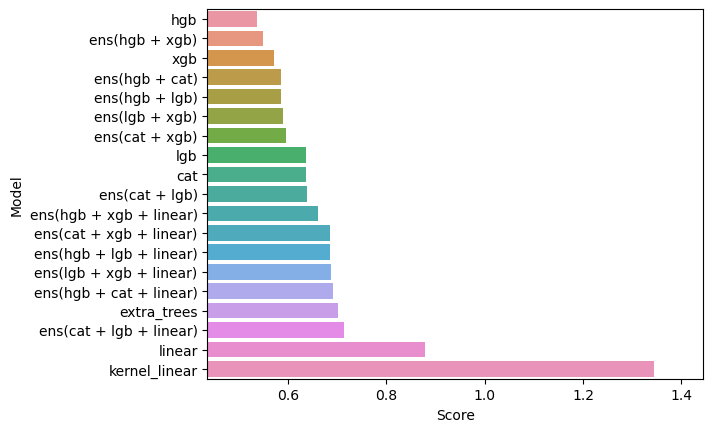

In [1157]:
# make a barplot to illustrate the scores of models and ensembles
fig = sns.barplot(resulting_reg_df, 
                  x='score', 
                  y='label')
fig.set(xlabel ='Score', ylabel = 'Model')
fig.set_xlim(resulting_reg_df.score.min() - 0.1, 
             resulting_reg_df.score.max() + 0.1) 

In [1158]:
# get label of the best model
best_model_label_reg = list(resulting_reg_df.loc[resulting_reg_df.score == resulting_reg_df.score.min()].label)[0]
best_model_label_reg

'hgb'

In [1159]:
# initialize the best model as best_model and fit it on a train set
if best_model_label_reg in list(best_models_reg_df.label):
    best_model_reg = models_reg[best_model_label_reg]['template'](best_models_reg[best_model_label_reg]['params'])
elif best_model_label_reg in list(ensembles_reg_df.label):
    best_model_reg = ensembles_reg[best_model_label_reg]['model']
else:
    best_model_reg = ensembles_reg_2[best_model_label_reg]['model']

HistGradientBoostingRegressor(l2_regularization=100, loss='absolute_error',
                              max_depth=5, min_samples_leaf=25, random_state=1)

___

### CLASSIFICATION

In [1165]:
train_cl = reform_target_to_multiclass(train)
X_cl = train_cl.drop('Hardness_Multiclass', axis=1)
y_cl = train_cl.Hardness_Multiclass

#### BASIC MODELS (classification)

In [1226]:
def cv_cl(model):
    """A func cross-validates input model and returns a MedAE-score"""
    splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    score_list = []
    for train_indexlist, validate_indexlist in splitter.split(X_cl, y_cl):
        X_t = train_cl.iloc[train_indexlist] ### 
        X_v = train_cl.iloc[validate_indexlist] ###
        y_t = X_t.pop('Hardness_Multiclass')
        y_v = X_v.pop('Hardness_Multiclass')
        model.fit(X_t, y_t)
        y_pred = model.predict(X_v)
        y_pred_float = np.array(reform_target_to_float(pd.DataFrame({'Hardness_Multiclass': y_pred.flatten()})).Hardness.values)
        y_v_float = np.array(reform_target_to_float(pd.DataFrame({'Hardness_Multiclass': y_v})).Hardness.values)
        score_list.append(median_absolute_error(y_v_float, y_pred_float))
    score = np.array(score_list).mean()
    return score

In [1222]:
# set a dict of models to analyze
models_cl = {
    # logistic regression
    'logr': {
        'params': {
            'C': [1]
        },
        'template': lambda params: make_pipeline(PolynomialFeatures(degree=4, 
                                                                    include_bias=False),
                                                 MinMaxScaler(),
                                                 LogisticRegression(**params, 
                                                                    random_state=1, 
                                                                    max_iter=1500))
    },
    
    # logistic regression with kernel approximation
    'kernel_logr': {
        'params': {
            'C': [1]
        },
        'template': lambda params: make_pipeline(Nystroem(n_components=400, 
                                                          random_state=1),
                                                 MinMaxScaler(),
                                                 LogisticRegression(**params, 
                                                                    random_state=1, 
                                                                    max_iter=1500))
    },
    
    # hist GB classifier
    'hgb': {
        'params': {
            'max_depth': [2],
            'min_samples_leaf': [25],
            'l2_regularization': [0]
        },
        'template': lambda params: HistGradientBoostingClassifier(**params, 
                                                                  random_state=1)
    },
    
    # XGBoost classifier
    'xgb': {
        'params': {
            'n_estimators': [100],
            'max_depth': [1, 2],
            'objective': ['multi:softmax', 'reg:absoluteerror'],
            'num_class': [11]
        },
        'template': lambda params: XGBClassifier(**params, 
                                                 random_state=1)
    },
    
    # light GB classifier
    'lgb': {
        'params': {
            'objective': ['multiclass'],
            'n_estimators': [25, 100, 300],
            'max_depth': [2, 3, 4]
        },
        'template': lambda params: LGBMClassifier(**params, 
                                                  verbose=-1, 
                                                  random_state=1)      
    },
    
    # cat boost classifier
    'cat': {
        'params': {
            'objective': ['MultiClass'],
            'depth': [1, 2, 3]
            
        },
        'template': lambda params: CatBoostClassifier(**params, 
                                                      silent=True, 
                                                      random_state=1)
    },
    
}

In [1215]:
# create a dict to store the scores and parameters of the best models
best_models_cl = {}
# for each model find the best score and parameters (e.g. fill best_models dict)
for modelname, data in models_cl.items():
    best_score = 1000
    best_params = {}
    for params in all_combinations(data['params']):
        model = data['template'](params)
        print('~ cross-validating {} model\n  with params {}\n\t...'.format(modelname, params))
        score = cv_cl(model)
        print('\tdone! MedAE-score: {0:.4f}\n'.format(score))
        if score < best_score:
            best_score = score
            best_params = params
    best_models_cl[modelname] = {
        'params': best_params,
        'score': best_score
    }

~ cross-validating logr model
  with params {'C': 1}
	...
	done! MedAE-score: 0.5000

~ cross-validating kernel_logr model
  with params {'C': 1}
	...
	done! MedAE-score: 1.0100

~ cross-validating hgb model
  with params {'max_depth': 2, 'min_samples_leaf': 25, 'l2_regularization': 0}
	...
	done! MedAE-score: 0.5000

~ cross-validating xgb model
  with params {'n_estimators': 100, 'max_depth': 1, 'objective': 'multi:softmax', 'num_class': 11}
	...
	done! MedAE-score: 0.5000

~ cross-validating xgb model
  with params {'n_estimators': 100, 'max_depth': 1, 'objective': 'reg:absoluteerror', 'num_class': 11}
	...
	done! MedAE-score: 0.5000

~ cross-validating xgb model
  with params {'n_estimators': 100, 'max_depth': 2, 'objective': 'multi:softmax', 'num_class': 11}
	...
	done! MedAE-score: 0.5000

~ cross-validating xgb model
  with params {'n_estimators': 100, 'max_depth': 2, 'objective': 'reg:absoluteerror', 'num_class': 11}
	...
	done! MedAE-score: 0.5000

~ cross-validating lgb model

In [1216]:
# print the content of best_models dict
for modelname in best_models_cl:
    print('The best {} model:\n\tscore: {}\n\tparams: {}\n'.format(modelname, 
                                                                   best_models_cl[modelname]['score'], 
                                                                   best_models_cl[modelname]['params']))

The best logr model:
	score: 0.5
	params: {'C': 1}

The best kernel_logr model:
	score: 1.0099999999999998
	params: {'C': 1}

The best hgb model:
	score: 0.5
	params: {'max_depth': 2, 'min_samples_leaf': 25, 'l2_regularization': 0}

The best xgb model:
	score: 0.5
	params: {'n_estimators': 100, 'max_depth': 1, 'objective': 'multi:softmax', 'num_class': 11}

The best lgb model:
	score: 0.475
	params: {'objective': 'multiclass', 'n_estimators': 100, 'max_depth': 3}

The best cat model:
	score: 0.5
	params: {'objective': 'MultiClass', 'depth': 1}



In [1217]:
# create a dataframe with best models' scores
best_models_cl_df = pd.DataFrame()
for modelname, data in best_models_cl.items():
    row = pd.DataFrame({'label': [modelname], 
                        'score': [data['score']]})
    best_models_cl_df = pd.concat([best_models_cl_df, row], 
                                  ignore_index=True)
best_models_cl_df = best_models_cl_df.sort_values(by='score', ascending=True).reset_index(drop=True)
best_models_cl_df

,label,score
0,lgb,0.475
1,logr,0.500
2,hgb,0.500
3,xgb,0.500
4,cat,0.500
5,kernel_logr,1.010


#### RESULT (classification approach)

(0.375, 1.1099999999999999)

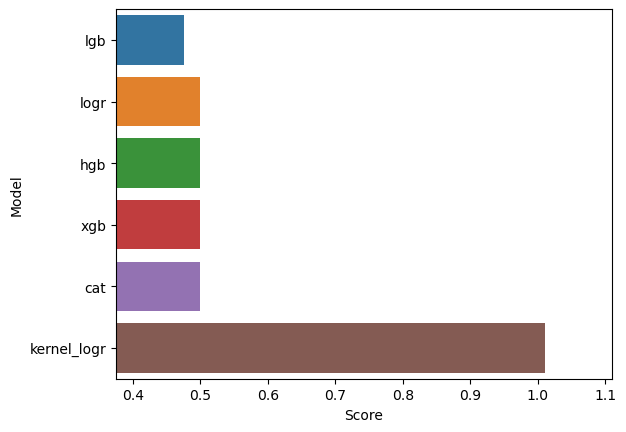

In [1228]:
# make a barplot to illustrate the scores of models and ensembles
fig = sns.barplot(best_models_cl_df, 
                  x='score', 
                  y='label')
fig.set(xlabel ='Score', ylabel = 'Model')
fig.set_xlim(best_models_cl_df.score.min() - 0.1, 
             best_models_cl_df.score.max() + 0.1) 

In [1230]:
# get label of the best model
best_model_label_cl = list(best_models_cl_df.loc[best_models_cl_df.score == best_models_cl_df.score.min()].label)[0]
best_model_label_cl

'lgb'

In [1231]:
# initialize the best model as best_model
best_model_cl = models_cl[best_model_label_cl]['template'](best_models_cl[best_model_label_cl]['params'])

LGBMClassifier(max_depth=3, objective='multiclass', random_state=1, verbose=-1)

___

### COMBINED APPROACH

In [1244]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, 
                                                                    y_reg, 
                                                                    test_size=0.3, 
                                                                    random_state=1)
X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(X_cl, 
                                                                y_cl, 
                                                                test_size=0.3, 
                                                                random_state=1)
display(best_model_reg.fit(X_train_reg, y_train_reg))
display(best_model_cl.fit(X_train_cl, y_train_cl))

preds_reg = best_model_reg.predict(X_test_reg)
preds_cl = best_model_cl.predict(X_test_cl)
preds_cl = np.array(reform_target_to_float(pd.DataFrame({'Hardness_Multiclass': preds_cl.flatten()})).Hardness.values)
y_true = np.array(y_test_reg)
preds = (preds_reg + preds_cl) / 2
display(preds_reg)
display(preds_cl)
display(preds)
display(y_true)

median_absolute_error(y_true, preds)

HistGradientBoostingRegressor(l2_regularization=100, loss='absolute_error',
                              max_depth=5, min_samples_leaf=25, random_state=1)

LGBMClassifier(max_depth=3, objective='multiclass', random_state=1, verbose=-1)

array([5.47470448, 2.50007457, 3.54285488, ..., 4.8143961 , 6.14565436,
       2.79445786])

array([6. , 3.8, 3.8, ..., 3.8, 6.5, 3.8])

array([5.73735224, 3.15003728, 3.67142744, ..., 4.30719805, 6.32282718,
       3.29722893])

array([6. , 3.8, 3.8, ..., 5. , 5.5, 3. ])

0.4987575038654004

In [1246]:
# fit models
display(best_model_reg.fit(X_reg, y_reg))
display(best_model_cl.fit(X_cl, y_cl))

HistGradientBoostingRegressor(l2_regularization=100, loss='absolute_error',
                              max_depth=5, min_samples_leaf=25, random_state=1)

LGBMClassifier(max_depth=3, objective='multiclass', random_state=1, verbose=-1)

___

### SUBMISSION

In [1250]:
# read the test set
test = pd.read_csv('test.csv', index_col='id').reset_index()
id_column = test.id
test

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
0,10407,884.0,121.420000,35.360000,5.280000,82.561240,9.370384,2.298000,1.907200,1.200000,0.461899,1.79459
1,10408,90.0,9.931960,18.000000,5.600000,39.568056,12.086300,2.868000,1.652000,0.864000,0.476196,1.41194
2,10409,116.0,7.767992,11.600000,4.800000,23.231818,11.023840,2.644000,1.794000,0.960000,0.499514,0.78834
3,10410,100.0,9.107996,10.000000,4.800000,20.298893,12.086300,2.828000,1.662000,0.792000,0.495796,1.20466
4,10411,55.0,4.030000,11.000000,4.000000,22.977675,11.280950,2.455000,1.750000,0.893333,0.476095,0.93456
...,...,...,...,...,...,...,...,...,...,...,...,...
6934,17341,446.0,36.135392,9.636364,4.636364,19.689448,11.045515,2.768636,1.769697,0.871818,0.498702,0.11548
6935,17342,36.0,3.550000,18.000000,4.000000,36.068500,8.236600,1.790000,2.055000,1.390000,0.499000,1.35045
6936,17343,68.0,4.545328,11.333333,5.333333,22.688853,10.938358,2.876667,1.713333,0.916667,0.499074,0.73425
6937,17344,40.0,2.334164,6.666667,4.000000,13.016128,12.700467,2.770000,1.476667,0.616667,0.663797,0.51227


In [1251]:
test.drop('id', axis=1, inplace=True)

In [1252]:
test = apply_clustering_for_test_set(test, fitted_clusterizer)
test

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,atomicweight_Average_ionenergy_Average_cl
0,884.0,121.420000,35.360000,5.280000,82.561240,9.370384,2.298000,1.907200,1.200000,0.461899,1.79459,1
1,90.0,9.931960,18.000000,5.600000,39.568056,12.086300,2.868000,1.652000,0.864000,0.476196,1.41194,2
2,116.0,7.767992,11.600000,4.800000,23.231818,11.023840,2.644000,1.794000,0.960000,0.499514,0.78834,0
3,100.0,9.107996,10.000000,4.800000,20.298893,12.086300,2.828000,1.662000,0.792000,0.495796,1.20466,0
4,55.0,4.030000,11.000000,4.000000,22.977675,11.280950,2.455000,1.750000,0.893333,0.476095,0.93456,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6934,446.0,36.135392,9.636364,4.636364,19.689448,11.045515,2.768636,1.769697,0.871818,0.498702,0.11548,0
6935,36.0,3.550000,18.000000,4.000000,36.068500,8.236600,1.790000,2.055000,1.390000,0.499000,1.35045,0
6936,68.0,4.545328,11.333333,5.333333,22.688853,10.938358,2.876667,1.713333,0.916667,0.499074,0.73425,0
6937,40.0,2.334164,6.666667,4.000000,13.016128,12.700467,2.770000,1.476667,0.616667,0.663797,0.51227,0


In [1253]:
preds_reg = best_model_reg.predict(test)
preds_cl = best_model_cl.predict(test)
preds_cl = np.array(reform_target_to_float(pd.DataFrame({'Hardness_Multiclass': preds_cl.flatten()})).Hardness.values)
preds = (preds_reg + preds_cl) / 2
preds

array([2.48240832, 2.44976689, 5.94785313, ..., 5.52335218, 4.44491915,
       3.44849649])

In [1254]:
submission = pd.DataFrame({'id': id_column, 
                           'Hardness': preds}).set_index('id')
submission.to_csv('submission_1.csv')